In [ ]:
%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
import requests
import folium
import pandas as pd
import matplotlib.pyplot as plt
from pystac_client import Client


In [2]:
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

In [3]:
# Nome da coleção e ativos
collection_name = "micasa-carbonflux-daygrid-v1"
asset_fire = "fire"  # Emissões de incêndios
asset_rh = "rh"      # Respiração heterotrófica

# Definir o bounding box para o Brasil (-74.0, -33.0, -34.0, 5.0)
bbox_brazil = [-74.0, -33.0, -34.0, 5.0]

In [ ]:
# Requisição para obter os itens da coleção no Brasil
response = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items", params={
    "bbox": bbox_brazil
}).json()

# Verificar o resultado da consulta
# items = response['features']
# print(f"Total de itens encontrados: {len(items)}")
print(response)


In [7]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for MiCASA Land Carbon Flux
collection_name = "micasa-carbonflux-daygrid-v1"

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the MiCASA Land Carbon Flux collection, the parameter of interest is “rh”
# rh = Heterotrophic Respiration
asset_name = "rh"

In [ ]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'requests' library allows a HTTP request possible
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items").json()

# Print the properties of the collection to the console
collection

In [ ]:
items = collection['features']
print(f"Total de itens encontrados: {len(items)}")

In [ ]:
# Função para filtrar os itens por tipo de ativo
def filter_by_asset_type(items, asset_type):
    return [item for item in items if asset_type in item['assets']]

# Filtrar por incêndios e respiração heterotrófica
fire_data = filter_by_asset_type(items, asset_fire)
rh_data = filter_by_asset_type(items, asset_rh)

print(f"Dados de incêndios: {len(fire_data)} itens")
print(f"Dados de respiração heterotrófica: {len(rh_data)} itens")


In [ ]:
# Criar um mapa centrado no Brasil
map_brazil = folium.Map(location=[-14.235, -51.9253], zoom_start=4)

# Adicionar camadas de incêndios
for item in fire_data:
    coords = item['geometry']['coordinates']
    folium.Marker(location=[coords[1], coords[0]], popup=item['id']).add_to(map_brazil)

# Exibir o mapa
map_brazil


In [ ]:
from rasterstats import zonal_stats

# Exemplo de uma área poligonal (você pode usar shapefiles ou GeoJSON para definir áreas maiores)
polygon = {
    "type": "Polygon",
    "coordinates": [[
        [-60, -10], [-60, 0], [-50, 0], [-50, -10], [-60, -10]
    ]]
}

# Executar as estatísticas zonais no dado de incêndios
zonal_fire_stats = zonal_stats(polygon, fire_data[0]['assets'][asset_fire]['href'], stats="sum")
print(zonal_fire_stats)

# Executar as estatísticas zonais no dado de respiração heterotrófica
zonal_rh_stats = zonal_stats(polygon, rh_data[0]['assets'][asset_rh]['href'], stats="sum")
print(zonal_rh_stats)


In [16]:
import requests
import json
import json

# Definir a URL da API e os parâmetros
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
collection_name = "micasa-carbonflux-daygrid-v1"
bbox_brazil = [-74.0, -33.0, -34.0, 5.0]

# # Fazer a requisição à API (usando /search para buscar com bbox)
# response = requests.post(f"{STAC_API_URL}/search", json={
#     "collections": [collection_name],
#     "bbox": bbox_brazil
# })

response = requests.post(f"{STAC_API_URL}/search", json={
    "collections": [collection_name],
    "bbox": bbox_brazil,
    "limit": 10  # Ajustar o limite para o máximo permitido
})


# Verificar o status HTTP da resposta
if response.status_code != 200:
    print(f"Erro na requisição: {response.status_code}")
    print(response.text)
else:
    # Converter a resposta para JSON e verificar o conteúdo
    data = response.json()
    # print(json.dumps(data, indent=4))  # Imprimir a resposta JSON formatada)

    # Tentar acessar os 'features', se existir
    if 'features' in data:
        all_items = data['features']
        print(f"Total de itens encontrados: {len(items)}")
    else:
        print("Nenhuma chave 'features' encontrada na resposta.")


Total de itens encontrados: 10


In [17]:
import matplotlib.pyplot as plt
from datetime import datetime

# Lista para armazenar as datas e as intensidades
datas = []
emissoes_incendio = []

# Suponha que `all_items` contenha todos os itens que você capturou da API
for item in all_items:
    # Extrair a data do item
    properties = item.get('properties', {})
    datetime_str = properties.get('datetime')
    
    # Extrair os dados de emissões de incêndio (fire) do campo 'assets'
    assets = item.get('assets', {})
    fire_data = assets.get('fire', {})
    
    # Extrair os metadados de interesse em raster:bands
    raster_bands = fire_data.get('raster:bands', [])
    if raster_bands:
        fire_stats = raster_bands[0].get('statistics', {})
        fire_mean = fire_stats.get('mean', 0)  # Valor médio de emissão de incêndio

        # Armazenar data e valor de emissão
        if datetime_str and fire_mean:
            datas.append(datetime.fromisoformat(datetime_str.replace("Z", "")))
            emissoes_incendio.append(fire_mean)

# Verificar os dados coletados
print(f"Total de registros: {len(emissoes_incendio)}")


Total de registros: 10


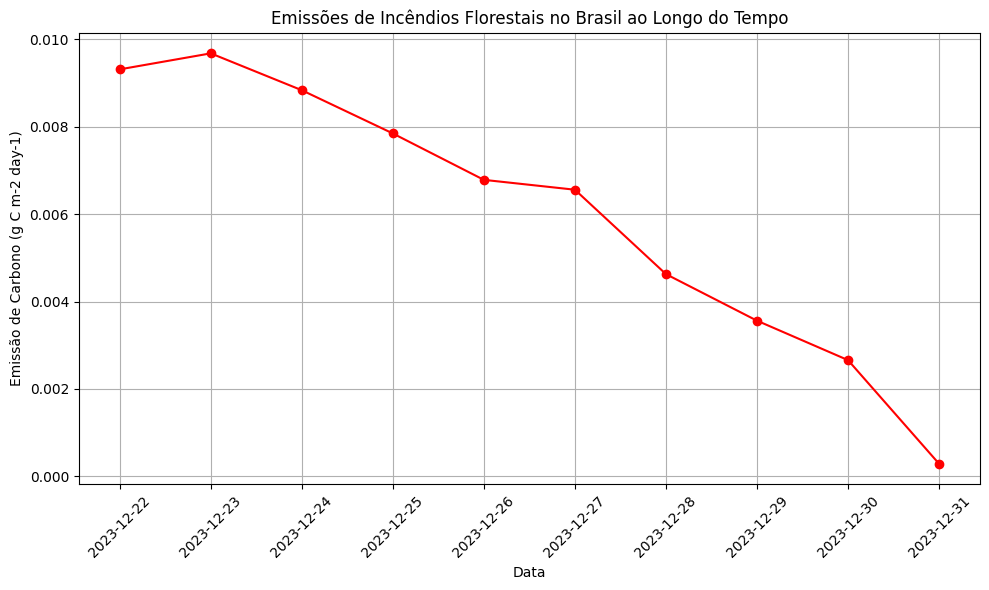

In [18]:
# Criar o gráfico de emissões de incêndio ao longo do tempo
plt.figure(figsize=(10, 6))

# Plotar a linha
plt.plot(datas, emissoes_incendio, marker='o', linestyle='-', color='red')

# Adicionar título e rótulos aos eixos
plt.title("Emissões de Incêndios Florestais no Brasil ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Emissão de Carbono (g C m-2 day-1)")

# Melhorar a visualização
plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
plt.grid(True)           # Adicionar uma grade

# Exibir o gráfico
plt.tight_layout()
plt.show()


In [19]:
# Limite de coordenadas do Brasil (aproximado)
bbox_brazil = [-74.0, -33.0, -34.0, 5.0]

# Filtrar os itens que estão dentro da bounding box do Brasil
for item in all_items:
    bbox = item.get('bbox', [])
    if bbox and bbox[0] >= bbox_brazil[0] and bbox[1] >= bbox_brazil[1] and bbox[2] <= bbox_brazil[2] and bbox[3] <= bbox_brazil[3]:
        # Este item está dentro do Brasil, prossiga com o processamento
        # (processar o mesmo código de extração de emissões)
        pass


In [ ]:
import requests

# Definir a URL da API e os parâmetros
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
collection_name = "micasa-carbonflux-daygrid-v1"
bbox_brazil = [-74.0, -33.0, -34.0, 5.0]

# Inicializar variáveis para armazenar todos os itens
all_items = []
limit = 1000  # Limite de itens por página
page = 1
has_more = True

while has_more:
    # Fazer a requisição à API (com paginação)
    response = requests.post(f"{STAC_API_URL}/search", json={
        "collections": [collection_name],
        "bbox": bbox_brazil,
        "limit": limit,
        "page": page  # Passar o número da página
    }).json()
    
    # Verificar se há 'features' na resposta
    if 'features' in response:
        items = response['features']
        all_items.extend(items)
        print(f"Página {page}: {len(items)} itens encontrados.")
        
        # Checar se há mais páginas (verificar contexto ou contagem)
        has_more = len(items) == limit  # Se a página tiver o máximo de itens, talvez haja mais
        page += 1
    else:
        has_more = False
        print("Nenhuma chave 'features' encontrada na resposta.")

print(f"Total de itens encontrados: {len(all_items)}")
